# **Iris predict**

In [2]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [106]:
# Main function 
def predictIris(path, save = False):
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)
    
   
# Show image    
def show_image(image_array):
    plt.figure(figsize=(4, 4))
    plt.imshow(image_array)
    plt.axis("off") 
    plt.show()
    # pass
        
# Load image
def load_img(path):
    image = Image.open(path)
    image_array = np.array(image)
    print("############# ORIGINAL EYE IMAGE #############")
    show_image(image_array)
    return image_array
    
# Convert to grayscale
def convert_to_grayscale(image_array):
    gray_image = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)
    gray_image = np.mean(image_array, axis=2)
    gray_image = np.array(gray_image, dtype=np.uint8)
    print("############# GRAY IMAGE #############")
    # show_image(np.dstack((gray_image, gray_image, gray_image)))
    return gray_image

# Binarize with threshold
def binarize_image(image_array, X):
    P = np.mean(image_array)
    threshold = P / X
    binary_image = np.zeros_like(image_array)
    binary_image[image_array > threshold] = 255
    show_image(np.dstack((binary_image, binary_image, binary_image)))
    return binary_image

# Clean pupil image
def clean_pupil(binary_image):
    kernel = np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],], dtype=np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)   

    clean_image = binary_image.copy()
    
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
    clean_image = cv2.erode(clean_image, kernel, iterations=2)
    clean_image = cv2.dilate(clean_image, kernel_small, iterations=2)
    clean_image = cv2.medianBlur(clean_image, 5)
 
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)
    return find_pupil(horizontal_projection, vertical_projection)

# Clean iris image
def clean_iris(binary_image):
    kernel_large = np.ones((10, 10), np.uint8)   
    kernel_medium = np.ones((5, 5), np.uint8)  
    kernel_small = np.ones((3, 3), np.uint8)  
    kernel_circle_small = np.array([[0, 1, 0],
                                 [1, 1, 1],
                                 [0, 1, 0]], dtype=np.uint8)
    clean_image = binary_image.copy() 

    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=1)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=5)
    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=5)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.dilate(clean_image, kernel_large, iterations=1)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=10)
    clean_image = cv2.blur(clean_image, (5, 5), 0)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel_large)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)   
    return find_iris(horizontal_projection, vertical_projection) 

def keep_largest_object(binary_image):
    # Odwracamy kolory: obiekt (0) -> (255), tło (255) -> (0)
    inverted_image = cv2.bitwise_not(binary_image)

    # Znajdujemy składowe połączone
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted_image, connectivity=8)

    if num_labels == 1:
        # Nie znaleziono żadnych obiektów
        return binary_image
    
    # Szukamy największego obiektu (pomijamy indeks 0, bo to tło)
    largest_label = 1 + np.argmax(stats[1:, 4])

    # Tworzymy nowy obraz binarny, gdzie zostaje tylko największy obiekt
    largest_object = np.zeros_like(binary_image, dtype=np.uint8)
    largest_object[labels == largest_label] = 255  # Ustawiamy największy obiekt na biały

    # Odwracamy kolory z powrotem: obiekt (255) -> (0), tło (0) -> (255)
    return cv2.bitwise_not(largest_object)

# Show projections
def show_projections(clean_image, binary_image):
    horizontal_projection = np.sum(clean_image, axis=1)  
    vertical_projection = np.sum(clean_image, axis=0)   
    height, width = clean_image.shape
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].imshow(np.dstack((clean_image, clean_image, clean_image)))
    axs[0, 0].set_title("Binary Image after Morphology")
    axs[0, 0].axis("off")
    axs[1, 1].axis("off")
    rect = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 1].plot(horizontal_projection, range(height), color='blue', linewidth=2)
    axs[0, 1].set_title("Horizontal Projection")
    axs[0, 1].set_ylim(height, 0)  
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].plot(range(width), vertical_projection, color='red', linewidth=2)
    axs[1, 0].set_title("Vertical Projection")
    axs[1, 0].set_xlim(0, width)  
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].imshow(np.dstack((binary_image, binary_image, binary_image)))
    axs[1, 1].set_title("Binary Image")
    rect2 = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[1, 1].add_patch(rect2)
    plt.tight_layout()
    plt.show()
    return horizontal_projection, vertical_projection

# Find pupil
def find_pupil(horizontal_projection, vertical_projection):
    y_pupil = int(np.median(np.where(horizontal_projection == np.min(horizontal_projection))[0]))
    x_pupil = int(np.median(np.where(vertical_projection == np.min(vertical_projection))[0]))

    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))
    
    pupil_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.3)[0]
    pupil_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.3)[0]
    if len(pupil_edges_y) > 1:
        r_pupil_y = (pupil_edges_y[-1] - pupil_edges_y[0]) // 2
    else:
        r_pupil_y = 0
    if len(pupil_edges_x) > 1:
        r_pupil_x = (pupil_edges_x[-1] - pupil_edges_x[0]) // 2
    else:
        r_pupil_x = 0 
    r_pupil = (r_pupil_x + r_pupil_y) // 2 # CZY TU LEPIEJ BRAĆ ŚREDNIĄ CZY JAKIŚ MAKS CZY COŚ INNEGO?
    return (x_pupil, y_pupil, r_pupil)

# Find iris
def find_iris(horizontal_projection, vertical_projection):
    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))

    iris_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.4)[0]
    iris_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.4)[0]

    if len(iris_edges_y) > 1:
        r_iris_y = (iris_edges_y[-1] - iris_edges_y[0]) // 2
    else:
        r_iris_y = 0

    if len(iris_edges_x) > 1:
        r_iris_x = (iris_edges_x[-1] - iris_edges_x[0]) // 2
    else:
        r_iris_x = 0 

    r_iris = (3 * r_iris_x + r_iris_y) // 4

    return r_iris

# Draw found iris and pupil
def draw_circle(image_array, x, y, r):
    image_with_circle = image_array.copy()
    image_with_circle = cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 1)
    return image_with_circle

def unwrap_iris(image, x_pupil, y_pupil, r_pupil, r_iris, output_shape=(64, 360), angle_offset=270):
    """
    Rozwija wykrytą tęczówkę do prostokątnej postaci.
    
    :param image: Obraz wejściowy (oryginalny, grayscale lub binarny)
    :param x_pupil: Współrzędna x środka źrenicy
    :param y_pupil: Współrzędna y środka źrenicy
    :param r_pupil: Promień źrenicy
    :param r_iris: Promień tęczówki
    :param output_shape: (wysokość, szerokość) wynikowego prostokątnego obrazu
    :param angle_offset: przesunięcie kąta początkowego (w stopniach), np. 30
    :return: Rozwinięty obraz tęczówki
    """
    height, width = output_shape
    # Konwersja przesunięcia do radianów
    offset_rad = np.deg2rad(angle_offset)
    # Używamy endpoint=False, by mieć dokładnie 360 stopni przy równomiernym podziale,
    # a następnie dodajemy przesunięcie.
    theta = np.linspace(0, 2 * np.pi, width, endpoint=False) + offset_rad  
    r = np.linspace(r_pupil, r_iris, height)  # Promienie od źrenicy do tęczówki
    
    # Tworzymy siatkę współrzędnych biegunowych
    theta_grid, r_grid = np.meshgrid(theta, r)
    
    # Zamiana na współrzędne kartezjańskie
    x_grid = (x_pupil + r_grid * np.cos(theta_grid)).astype(int)
    y_grid = (y_pupil + r_grid * np.sin(theta_grid)).astype(int)
    
    # Usunięcie punktów poza obrazem
    x_grid = np.clip(x_grid, 0, image.shape[1] - 1)
    y_grid = np.clip(y_grid, 0, image.shape[0] - 1)
    
    # Tworzenie rozwiniętego obrazu
    unwrapped_iris = image[y_grid, x_grid]
    
    return unwrapped_iris


def compute_1d_representation(band):
    """
    Dla danego pasa tęczówki (obrazu 3-kanałowego) oblicza jednowymiarowy sygnał.
    Najpierw przekształcamy obraz na skalę szarości (średnia z kanałów),
    a następnie uśredniamy każdą kolumnę z wagami określonymi oknem Gaussowskim,
    które preferuje centralne wartości.
    """
    h, w, c = band.shape
    # Konwersja do skali szarości – możemy uśrednić wszystkie kanały
    band_gray = band.mean(axis=2)
    
    # Tworzymy wektor wag – okno Gaussowskie, centrum w h/2, std = h/4 (można dostroić)
    y = np.arange(h)
    sigma_window = h / 4.0
    window = np.exp(-((y - h / 2.0) ** 2) / (2 * sigma_window ** 2))
    window = window.reshape(-1, 1)  # kolumna
    
    # Uśrednianie z wagami wzdłuż osi pionowej (dla każdej kolumny)
    weighted_sum = np.sum(band_gray * window, axis=0)
    norm = np.sum(window)
    signal = weighted_sum / norm
    
    return signal

# Funkcja wyznaczająca 1-wymiarowe współczynniki Gabor dla sygnału
def compute_gabor_coefficients(signal, f, num_coeffs=128):
    """
    Dla jednowymiarowego sygnału I(x) wyznacza współczynniki rozwinięcia Gaborowych.
    Przyjmujemy:
      c_k = sum_{i=0}^{L-1} I[i] * exp(-((i - x_k)^2)/(sigma^2)) * exp(-i2π f i)
    gdzie sigma = 1/(2π f), a x_k to centra falek wybrane równomiernie (num_coeffs elementów).
    """
    L = len(signal)
    centers = np.linspace(0, L - 1, num_coeffs)
    sigma = 0.5 * np.pi * f
    coeffs = []
    indices = np.arange(L)
    for x0 in centers:
        # Okno Gaussowskie o środku x0
        gaussian_window = np.exp(-((indices - x0) ** 2) / (sigma ** 2))
        # Modulacja zespolona
        modulation = np.exp(-1j * 2 * np.pi * f * indices)
        c = np.sum(signal * gaussian_window * modulation)
        coeffs.append(c)
    return np.array(coeffs)

# Funkcja kodująca pojedynczy współczynnik na podstawie fazy (argumentu)
def encode_coefficient(c):
    """
    Koduje współczynnik c (liczbę zespoloną) do 2-bitowego ciągu według fazy:
      - Faza w [0, π/2)   -> "00"
      - Faza w [π/2, π]   -> "01"
      - Faza w (-π, -π/2] -> "11"
      - Faza w (-π/2, 0)  -> "10"
    """
    angle = np.angle(c)  # zakres (-π, π]
    if 0 <= angle < np.pi / 2:
        return "00"
    elif np.pi / 2 <= angle <= np.pi:
        return "01"
    elif -np.pi <= angle <= -np.pi / 2:
        return "11"
    elif -np.pi / 2 < angle < 0:
        return "10"
    else:
        return "00"  # zabezpieczenie

# Funkcja obliczająca kod dla jednego pasa tęczówki
def compute_band_iris_code(band, f, num_coeffs=128):
    """
    Dla pojedynczego pasa (2D) tęczówki:
      1. Obliczamy jednowymiarową reprezentację (uśrednianie kolumnowe z oknem Gaussowskim).
      2. Wyznaczamy num_coeffs współczynników Gabor przy użyciu stałej częstotliwości f.
      3. Każdy współczynnik kodujemy na 2-bitowy ciąg.
    Zwracany wynik to ciąg bitowy o długości 2*num_coeffs.
    """
    signal = compute_1d_representation(band)
    coeffs = compute_gabor_coefficients(signal, f, num_coeffs)
    band_code = "".join(encode_coefficient(c) for c in coeffs)
    return band_code

# Funkcja składająca kod z całej tęczówki (dzielonej na num_bands pasów)
def compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=256):
    """
    Cały kod tęczówki obliczamy w następujący sposób:
      1. Z rozwiniętego obrazu tęczówki wyodrębniamy 8 centralnych pasów,
         o stałej szerokości (output_width), aby zapewnić spójność.
      2. Dla każdego pasu wyznaczamy 2-bitowy kod (przy użyciu transformacji Gabora).
      3. Łączymy wyniki dla poszczególnych pasów.
    Zwracany ciąg bitów ma długość num_bands * (2 * num_coeffs).
    """
    bands = extract_central_bands(unwrapped_iris, output_width)
    full_code = ""
    for band in bands:
        band_code = compute_band_iris_code(band, f, num_coeffs)
        full_code += band_code
    return full_code

# Integracja z istniejącym pipeline (funkcje load_img, convert_to_grayscale, binarize_image, clean_pupil,
# clean_iris, draw_circle, unwrap_iris, show_image – zakładamy, że są już zdefiniowane)

def predictIris_with_daugman(path, f=0.1, save=False, output_width=256):
    """
    Rozszerzona funkcja przetwarzania zdjęcia tęczówki, która dodatkowo
    wyznacza kod tęczówki zgodnie z opisem z sekcji 6.2.2.2.
    Parametr f (częstotliwość) dobiera się eksperymentalnie - przykładowo f=0.1.
    """
    # Ładujemy i przygotowujemy obraz
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)

    visualize_band_boundaries(unwrapped_iris)    

    bands = extract_central_bands(unwrapped_iris, output_width)
    visualize_bands(bands)
    
    # Wyznaczanie kodu tęczówki według metody Daugmana
    print("############# COMPUTING IRIS CODE #############")
    iris_code = compute_full_iris_code(unwrapped_iris, f, num_bands=8, num_coeffs=128, output_width=output_width)
    print("Iris Code (binary):")
    print(iris_code)
    
    return iris_code

def visualize_iris_code_by_band(iris_code: str, num_bands: int = 8):
    """
    Wizualizuje kod tęczówki w postaci obrazu czarno-białego, gdzie:
      - każdy z 8 wierszy odpowiada jednemu pasowi,
      - kolumny to kolejne bity danego pasa.
    
    Parametry:
      iris_code  - ciąg bitów (np. "010101...") stanowiący kod tęczówki
      num_bands  - liczba pasów (domyślnie 8)
    """
    total_bits = len(iris_code)
    if total_bits % num_bands != 0:
        raise ValueError("Długość kodu nie jest podzielna przez liczbę pasów.")
    
    bits_per_band = total_bits // num_bands
    # Tworzymy tablicę o wymiarach (8 wierszy, bits_per_band kolumn)
    arr = np.zeros((num_bands, bits_per_band), dtype=np.uint8)
    
    # Wypełniamy każdy wiersz (pas) odpowiednim fragmentem bitów
    for band_index in range(num_bands):
        start = band_index * bits_per_band
        stop = (band_index + 1) * bits_per_band
        segment = iris_code[start:stop]
        
        # '1' → 1 (czarny), '0' → 0 (biały)
        for i, bit in enumerate(segment):
            arr[band_index, i] = 1 if bit == '1' else 0

    # Wyświetlamy całość
    plt.figure(figsize=(bits_per_band/16, num_bands/3))
    # vmin=0, vmax=1 -> 0=biały, 1=czarny (w cmap='gray' czarny będzie 1)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1, aspect='auto')
    plt.axis('off')  # usuwamy osie dla czytelnego efektu
    plt.show()


def extract_central_bands(unwrapped_iris, output_width, vertical_crop_ratio=1):
    """
    Wyodrębnia 8 poziomych pasów z obrazu rozwiniętej tęczówki (unwrapped iris),
    przy czym:
      - Najpierw opcjonalnie wycinek centralny w pionie jest pobierany (vertical_crop_ratio określa,
        jaka część wysokości obrazu zostanie zachowana, np. 0.8 = 80% centralnego regionu).
      - Centralny fragment jest dzielony równomiernie na 8 poziomych (radialnych) pasów.
      - Dla każdego pasu wykonywany jest poziomy (kątowy) wycinek:
           • Pasy 1-4: odpowiadają zakresowi 330°.
           • Pasy 5-6: odpowiadają zakresowi 226°.
           • Pasy 7-8: odpowiadają zakresowi 180°.
      - Pełna szerokość obrazu odpowiada 360°.
      - Następnie każdy wycięty fragment jest reskalowany do stałej szerokości output_width.
      
    Parametry:
      unwrapped_iris      - obraz rozwiniętej tęczówki (np. grayscale lub kolorowy); kształt (h, w) lub (h, w, c)
      output_width        - docelowa szerokość każdego pasu po reskalowaniu (w pikselach)
      vertical_crop_ratio - stosunek wysokości centralnego regionu do pełnej wysokości obrazu (domyślnie 0.8)
      
    Zwraca:
      bands - lista 8 obrazów (każdy odpowiada jednemu poziomemu pasowi)
    """
    # Ustalanie rozmiarów wejściowego obrazu
    if len(unwrapped_iris.shape) == 3:
        h, w, c = unwrapped_iris.shape
    else:
        h, w = unwrapped_iris.shape

    # Opcjonalne przycięcie pionowe – wybieramy centralny fragment, aby uniknąć górnych/dolnych artefaktów (np. powiek)
    crop_top = int((1.0 - vertical_crop_ratio) / 2 * h)
    crop_bottom = h - crop_top
    central_region = unwrapped_iris[crop_top:crop_bottom, :]
    new_h, new_w = central_region.shape[:2]
    
    # Podział centralnego regionu na 8 poziomych pasów
    band_height = new_h // 8
    bands = []
    for i in range(8):
        band = central_region[i * band_height : (i + 1) * band_height, :]
        
        # Określenie poziomego wycinka dla danego pasa na podstawie jego indeksu
        # Przyjmujemy, że cała szerokość obrazu odpowiada 360°.
        # Obliczamy docelowy zakres kątowy (w stopniach) w zależności od pasu:
        if i < 4:
            angular_span = 330.0  # pasy 1–4
        elif i < 6:
            angular_span = 226.0  # pasy 5–6
        else:
            angular_span = 180.0  # pasy 7–8
        
        # Obliczamy szerokość wycinka w pikselach: 
        # Jeśli pełne 360° odpowiada szerokości new_w, to wycinek odpowiada angular_span.
        crop_width = int(round(angular_span / 360.0 * new_w))
        center_x = new_w // 2
        x0 = center_x - crop_width // 2
        x1 = x0 + crop_width
        
        # Wycinek poziomy
        band_cropped = band[:, x0:x1]
        
        # Reskalowanie poziome do stałej szerokości output_width (przy zachowaniu oryginalnej wysokości pasu)
        band_resized = cv2.resize(band_cropped, (output_width, band_cropped.shape[0]), interpolation=cv2.INTER_LINEAR)
        bands.append(band_resized)
    
    return bands

def visualize_bands(bands):
    """
    Skleja 8 poziomych pasów (obrazów) pionowo i wyświetla wynik.
    Każdy pas odpowiada poziomemu wycinkowi rozwiniętej tęczówki.
    """
    # Upewnij się, że wszystkie pasy mają tę samą wysokość
    min_height = min(band.shape[0] for band in bands)
    bands_equal = [band[:min_height, :] for band in bands]
    
    # Sklejamy pasy pionowo
    stacked = np.vstack(bands_equal)
    
    # Zwiększamy rozmiar wykresu – podwajamy poprzedni rozmiar
    plt.figure(figsize=(stacked.shape[1] / 50, stacked.shape[0] / 50))
    plt.imshow(stacked, cmap='gray', aspect='auto')
    plt.title("Wyodrębnione poziome pasy tęczówki")
    plt.axis('off')
    plt.show()


def visualize_band_boundaries(unwrapped_iris, vertical_crop_ratio=1):
    """
    Na obrazie rozwiniętej tęczówki (unwrapped iris) nakłada oznaczenia pokazujące:
      1. Pionowe granice centralnego regionu (wycięcie górnej i dolnej części, np. powiek).
      2. Poziomy podział centralnego regionu na 8 równych pasów.
      3. W obrębie każdego pasa – pionowe granice poziomego wycinka, 
         odpowiadającego zakresowi kątowemu (różne dla pasów 1-4, 5-6 i 7-8).
         
    Parametry:
       unwrapped_iris      - obraz rozwiniętej tęczówki (np. grayscale lub kolorowy),
                             którego pełna szerokość odpowiada 360°.
       vertical_crop_ratio - stosunek wysokości centralnego regionu do całej wysokości obrazu.
    """
    h, w = unwrapped_iris.shape[:2]
    
    # Wyznaczamy pionowe przycięcie: zachowujemy centralny fragment, aby ominąć artefakty powiek.
    crop_top = int((1.0 - vertical_crop_ratio) / 2 * h)
    crop_bottom = h - crop_top
    central_region = unwrapped_iris[crop_top:crop_bottom, :]
    new_h, new_w = central_region.shape[:2]  # new_w powinno być równe w
    
    # Podział centralnego regionu na 8 równych poziomych pasów
    num_bands = 8
    band_height = new_h / num_bands
    
    # Przygotowujemy wykres z oryginalnym obrazem (pełny unwrapped iris)
    plt.figure(figsize=(w/50, h/50))
    plt.imshow(unwrapped_iris, cmap='gray', aspect='auto')
    
    # Rysujemy pionowe linie pokazujące, że zachowany został tylko centralny region
    plt.axhline(y=crop_top, color='cyan', linestyle='-', linewidth=2, label='Centralny region')
    plt.axhline(y=crop_bottom, color='cyan', linestyle='-', linewidth=2)
    
    # Rysujemy poziomy podział centralnego regionu na 8 równych pasów
    for i in range(1, num_bands):
        y_line = crop_top + i * band_height
        plt.axhline(y=y_line, color='red', linestyle='--', linewidth=2)
    
    # Dla każdego pasu wyznaczamy poziomy wycinek (czerwony fragment) – granice, które zostały zachowane:
    # Zgodnie z algorytmem, dla danego pasa:
    #  - Jeśli i < 4: angular_span = 330°
    #  - Jeśli 4 <= i < 6: angular_span = 226°
    #  - Jeśli i >= 6: angular_span = 180°
    # Cała szerokość centralnego regionu odpowiada 360°.
    center_x = new_w // 2
    for i in range(num_bands):
        # Obliczenie pionowych granic pasu (w globalnych współrzędnych obrazu)
        y0 = crop_top + i * band_height
        y1 = y0 + band_height
        
        if i  >= 4:
            angular_span = 330.0
        elif i  >= 2:
            angular_span = 226.0
        else:
            angular_span = 180.0
        
        # Obliczamy szerokość wycinka w pikselach, przyjmując, że 360° odpowiada new_w pikseli
        crop_width = int(round(angular_span / 360.0 * new_w))
        x0 = center_x - crop_width // 2
        x1 = x0 + crop_width
        
        # Aby narysować te granice na oryginalnym obrazie, musimy uwzględnić, że central_region
        # zaczyna się na crop_top – więc współrzędne poziome są takie same, ale pionowe przesunięte.
        plt.axvline(x=x0, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
        plt.axvline(x=x1, ymin=(y0/h), ymax=(y1/h), color='yellow', linestyle='-.', linewidth=2)
    
    plt.title("Granice centralnego regionu i wyciętych fragmentów pasów tęczówki")
    plt.axis('off')
    plt.show()

## Simple example

############# ORIGINAL EYE IMAGE #############


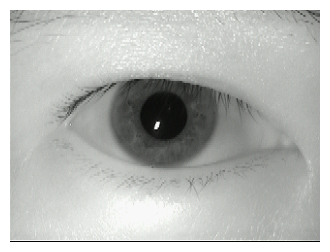

############# GRAY IMAGE #############
############# BINARY IMAGE FOR PUPIL #############


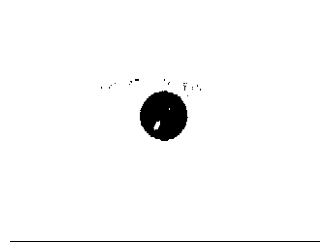

############# BINARY IMAGE FOR IRIS #############


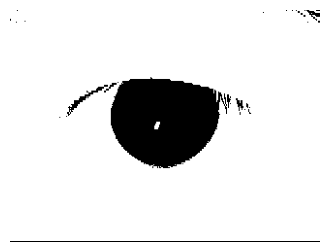

############# PUPIL EXTRACTED #############


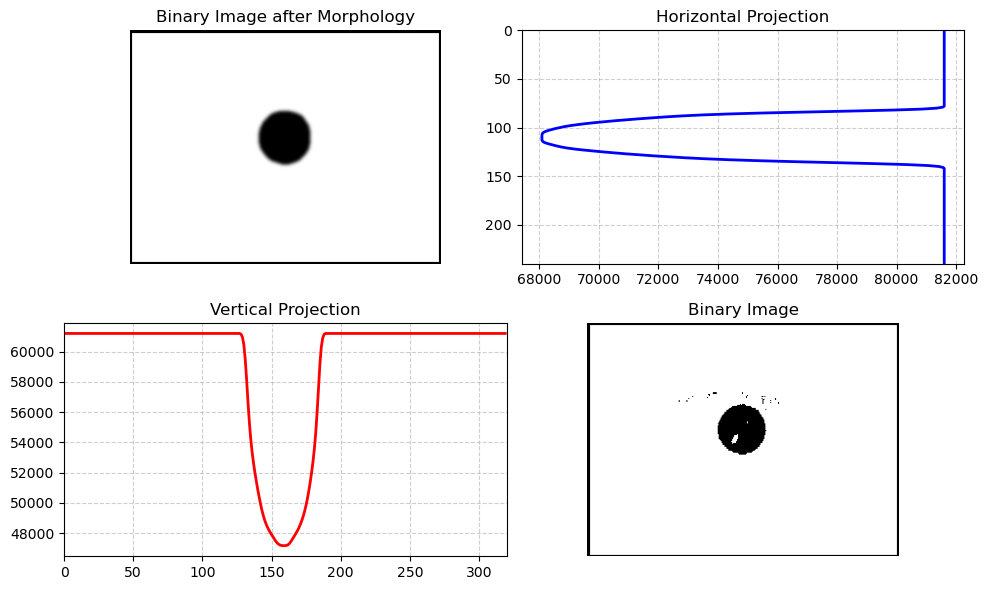

############# IRIS EXTRACTED #############


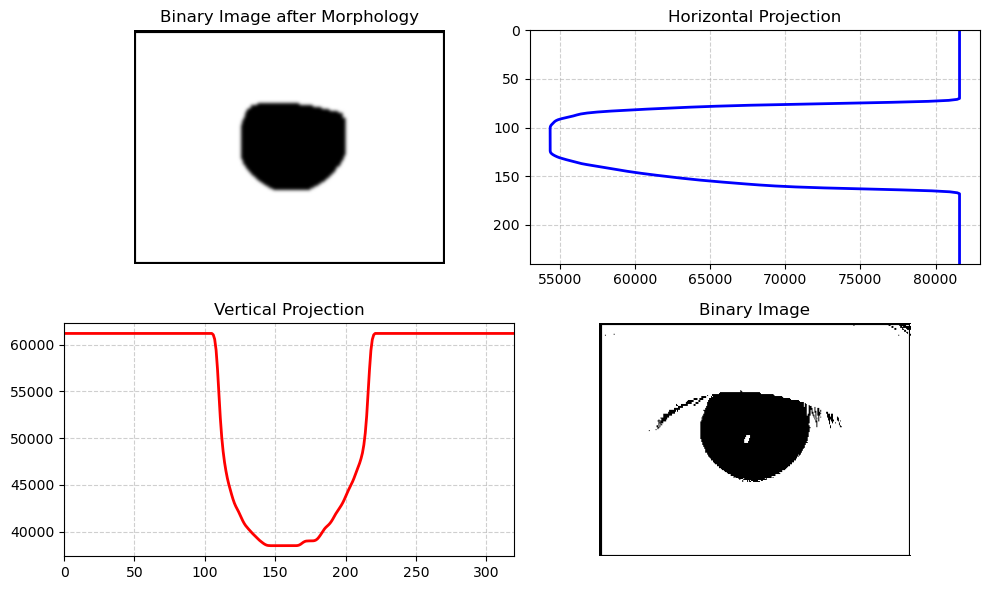

############# FOUND PUPIL AND IRIS #############


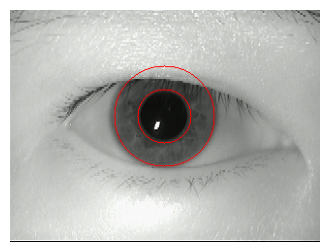

############# UNWRAPPED IRIS #############


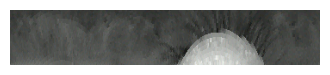

In [85]:
person_id = 42
eye = 'right'
photo_number = 4
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

predictIris(path)

In [ ]:
for file in os.listdir("data"):
    if file.endswith(".bmp"):
        file_path = os.path.join("data", file)
        print(f"Processed {file_path}")
        predictIris(file_path, save=True)


############# ORIGINAL EYE IMAGE #############


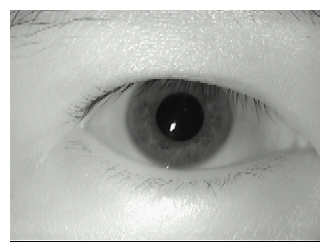

############# GRAY IMAGE #############
############# BINARY IMAGE FOR PUPIL #############


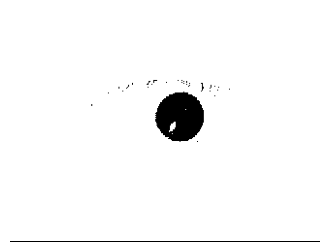

############# BINARY IMAGE FOR IRIS #############


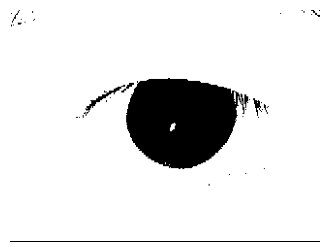

############# PUPIL EXTRACTED #############


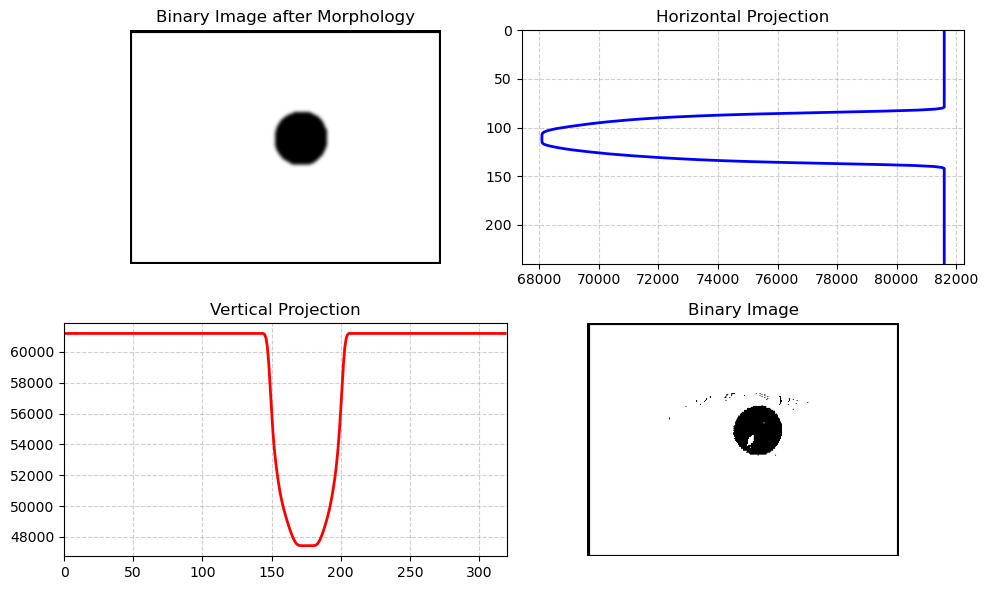

############# IRIS EXTRACTED #############


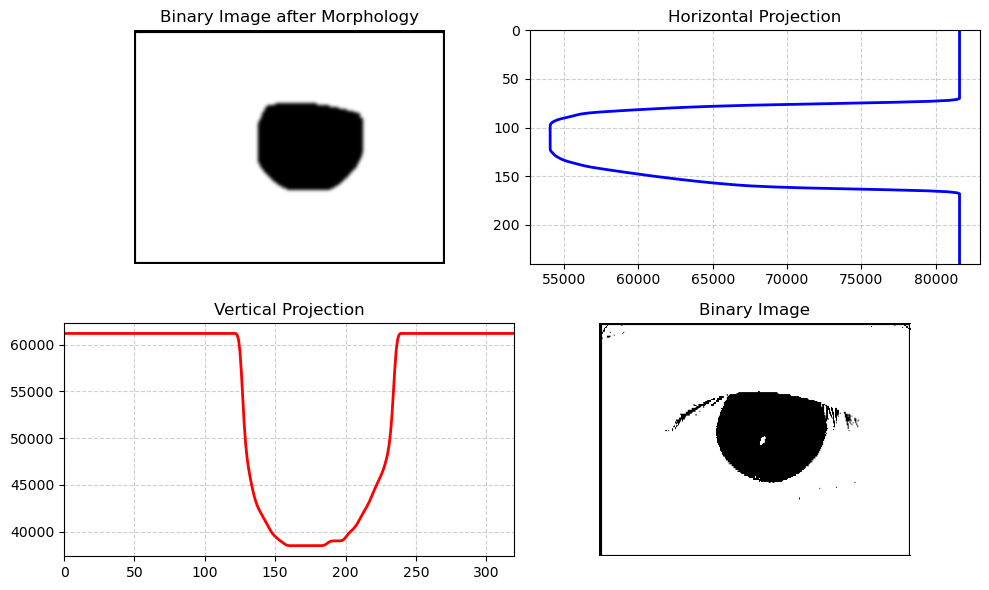

############# FOUND PUPIL AND IRIS #############


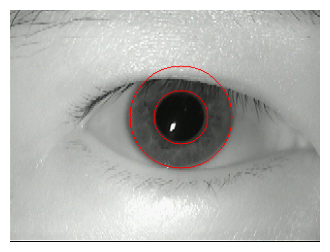

############# UNWRAPPED IRIS #############


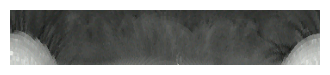

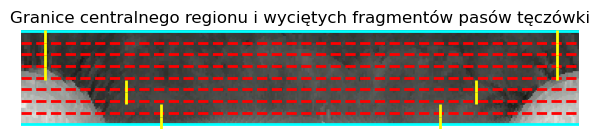

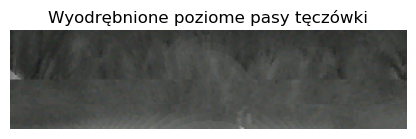

############# COMPUTING IRIS CODE #############
Iris Code (binary):
10000111101000011110100001111010000111101000011110100001111010000111101000011110100001111110000111111000010111100001011110000001111010000111111000011111100001011110000101111000000111100000011110000001111000000111100000011110000001111000000111100000011110001000011110100001111010000111101000011110100001111010000111101000011110100001111110000111111000011111100001011110000101111000000111101000011110100001011110000101111000010111100000011110000001111000000111100000011110000001111000000111100000011110000001111000100001111010000111101000011110100001111010000111101000011110100001111010000111101000011111100001111110000101111000010111100000011110100001111110000111111000010111100001011110000001111000000111100000011110000001111000000111100000011110000001111000000111100010000111101000011110100001111010000111101000011110100001111010000111101000011110100001111110000111111000010111100001011110000001111010000111111000011111100001011110

In [108]:
person_id = 42
eye = 'right'
photo_number = 3
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

irisCode = predictIris_with_daugman(path, 0.4)

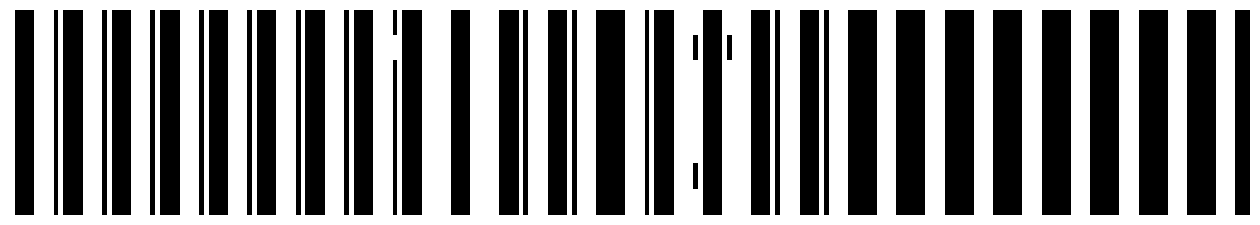

In [110]:
visualize_iris_code_by_band(irisCode, num_bands=8)